First the boltzmann machine has weights between two given units. We can denote as $w_{ij}$

In [144]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")

In [226]:
class SymmetricWeights:
	def __init__(self, units):
		self.units = units
		self.data = []
		for i in range(units):
			r = []
			for j in range(units):
				if(i < j):
					r.append(random.random())
				else:
					r.append(None)
			self.data.append(r)

	def __setitem__(self, tup, newv):
		i,j = tup
		assert(i != j)
		if i > j:
			i, j = j, i
		self.data[i][j] = newv
	def __getitem__(self, tup):
		i,j = tup
		assert(i != j)
		if i > j:
			i, j = j, i
		return self.data[i][j]

	def __repr__(self):
		return str(self.data)

w = SymmetricWeights(5)

In [227]:
for i in range(5):
	for j in range(5):
		if(i < j):
			print(w[i, j], end=" ")
		else:
			print("None", end=" ")
	print()

None 0.7213777656443376 0.9033245823117353 0.17765203587827372 0.7545789156251825 
None None 0.24865773965974758 0.175275913204323 0.3569747372618538 
None None None 0.7027529560218982 0.4823324629992336 
None None None None 0.33771973290901913 
None None None None None 


next I'll visualize this symmetric matrix via matplotlib

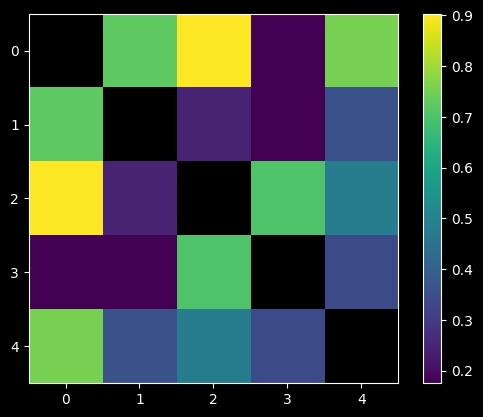

In [228]:

def visualize_weights(w: SymmetricWeights):
	full = []
	for i in range(w.units):
		f = []
		for j in range(w.units):
			if(i != j):
				f.append(w[i, j])
			else:
				f.append(np.NaN)
		full.append(f)
	plt.imshow(np.array(full))
	plt.colorbar()
visualize_weights(w)

Next I will define the actual Units. There will be visible units which I set my data to and there will be hidden units which learn in addition to the visible units. One of the underrated contributions of the paper!

The units can simply be defined as some adjacent units that we set.

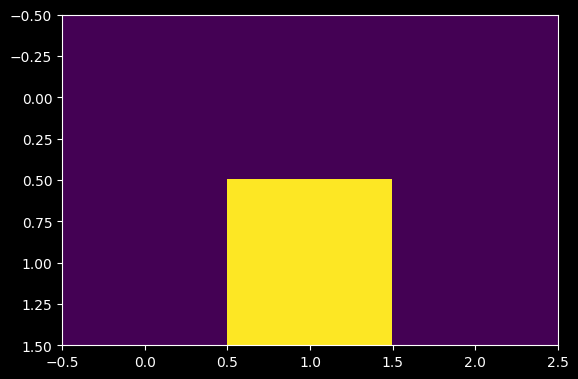

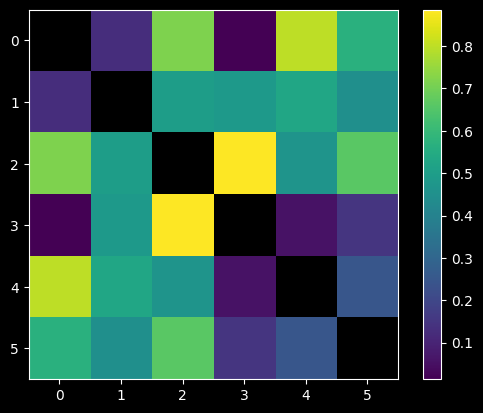

In [229]:
class Unit:
	def __init__(self):
		self.state = 1 if random.random() > 0.5 else 0

	def set_random_state(self):
		self.state = 1 if random.random() > 0.5 else 0

	def __repr__(self):
		return f"Unit(s={self.state})"

def visualize_units(units: list[Unit], shape):
	full = []
	for i in range(shape[0]):
		f = []
		for j in range(shape[1]):
			f.append(units[i*shape[1] + j].state)
		full.append(f)
	plt.imshow(np.array(full))

num_visible_units = 3
num_hidden_units = 3
total_units = num_visible_units + num_hidden_units 
visible_units = [Unit() for _ in range(num_visible_units)]
hidden_units = [Unit() for _ in range(num_hidden_units)]
units = [*visible_units, *hidden_units]

weights = SymmetricWeights(total_units)

visualize_units(units, (2,3))
plt.show()
visualize_weights(weights)

I can compute the energy of the given model by the equation

$$E = -\sum_{i<j} w_{ij} s_i s_j$$

Or you could think of it as the energy of each unit summed

$$E = -\sum_i E_i$$

In [230]:
def energy(units: list[Unit], w: SymmetricWeights):
	s = [u.state for u in units]
	summed = 0.0
	for i in range(len(units)):
		for j in range(len(units)):
			if i < j:
				summed += w[i,j]*s[i]*s[j]
	return -summed

energy(units, weights)

-0.0

So given my random weights and random state assignment, I get that energy!

With Boltzmann machines, I essentially want to minimize energy which corresponds to neighbors strengthening connections or weakening connections as I want to represent the data within the network.

Energy can be lowered pretty easily. If given a particular activation of a unit, we can compute how energy would change if we end up changing the values.

Going from 0 to 1 we get that the change in energy of a particular 

If a value is at 0, then a given energy $E_i = -\sum_{a\neq i} s_a s_i w_{ai} = 0$ since $s_i = 0$ and $a$ refers to the index of all other adjacent nodes.

If a value is at 1, then a given energy $E_i = -\sum_{a\neq i} s_a s_i w_{ai} = -\sum_{a\neq i} s_a w_{ai}$ since $s_i = 1$ and $a$ refers to the index of all other adjacent nodes again.

So I can just denote the change as the energy gap $$\Delta E_i = \sum_{a\neq i}s_a w_{ai}$$

In the original paper a $-\theta_i$ is subtracted which just shows if we want a threshold, or for the energy to minimize at all it has to exceed said threshold, in our case is just 0. So any contribution will be changing the energy here for us.


## Training

Now we could just this alone to update the connections, which is what hopfield networks are doing.

But this paper adds in randomness to get out of local minima. They do that by sampling to determine the activations rather than a set energy rule.

They sample by running the energies through a boltzmann distribution which essentially converts energies into probabilities.

They they choose 0 or 1 by just doing random uniform being below or over the value sampled from the distribution.

How do you derive this formulation. Easy peasy, take a given energy we already have $E_i$. Run it through boltzmann distribution at a given temperature T (I'll choose T=1), then random sample compare to that value, if below, snap to 1. 

The boltzmann distribution is an exponential distribution where given a state the prob of state is $e^{-s}/Q$ and since there are two possible states for a given state, we have that the normalizing value is $e^{-on} + e^{-off} = Q$

Then to just get $e^{-on}/Q = e^{-on}/\left(e^{-on} + e^{-off}\right) = 1/(1+e^{-\Delta E_i})$


So I can get the probability distribution first as


In [231]:
import math

def energy_gap(i, s, w):
	summed = 0.0
	for a in range(len(s)):
		if a != i:
			summed += s[a]*w[a,i]
	return summed

def states(units):
	return [u.state for u in units]

def p_i(i, s, w, T=1):
	gap = energy_gap(i, s, w)
	return 1 / (1 + math.exp(-gap/T))

def sample(p):
	return 1 if random.random() < p else 0

sample(p_i(0, states(units), weights))

1

Now how do I train this thing?

Well I'm trying to adjust the weights such that associations between weights fire together. So I should be trying to maximize the probability that my given boltzmann machine weights fit the data.

So $P(data; w) = \Pi_{i} P(x_{i}; w)$ also maximized by log

as $\log P(data; w) = \sum_{i} \log P(x_{i}; w)$

and $\log P(data; w) = -1/T \sum_{i}E(x_i) + \log Q_i$

Which means i need to minimize  the energy and the normalizer.

I can minimize these in two phases where I have the positive and negative update rules

the positive, I simply change the weights as the average the states and negative subtract but same average.

In [232]:
data = [[0,0,0],
		[0,1,0],
		[1,0,0],
		[1,1,1]]

In [ ]:
def train():
    for i in range(len(data)):
        # forward positive
        d = data[i]
        # clamp and initialize hidden states to random
        for v, s in zip(visible_units, d):
            v.state = s
        for v in hidden_units:
            v.set_random_state()

        # iterate over each hidden nodes and estimate the state
        for i in range(len(hidden_units)):
            hidden_units[i].state = sample(p_i(i, states(hidden_units), weights))

        positive_hidden_states = [v.state for v in hidden_units]
        positive_visible_states = [v.state for v in visible_units]

        # backward negative
        # Here we let the inputs now move freely and estimate it's data
        for i in range(len(visible_units)):
            visible_units[i].state = sample(p_i(i, states(visible_units), weights))

        negative_hidden_states = [v.state for v in hidden_units]
        negative_visible_states = [v.state for v in visible_units]

        # Now update the weights
        lr = 1e-1
        for i in range(weights.units):
            for j in range(weights.units):
                if i < j:
                    print(i, positive_visible_states[i])
                    weights[i, j] += lr * (
                        positive_visible_states[i] * positive_hidden_states[j]
                        - negative_visible_states[i] * negative_hidden_states[j]
                    )
train()

0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
2 0
2 0
2 0


IndexError: list index out of range